# Experimental Results of Octave UNet on Retinal Vessel Segmentation

---

## Ablation Study of Octave UNet on DRIVE dataset

---

This ablation study compares the retinal vessel segmentation performances of various Octave UNets with different $\alpha$, where $\alpha$ is the hyper-parameter that controls the ratio of low-frequency feature to both high- and low- frequency components of the model. For example, when the $\alpha$ is set to 0, an octave UNet degenerats into a vanilla UNet, while an octave UNet with $\alpha$ of 0.5 will process $50\%$ of low frequency features and $50\%$ of high frequency features.


In [1]:
# setup path environment
import os
import sys

project_dir, _ = os.path.split(os.getcwd())
if project_dir not in sys.path:
    sys.path.append(project_dir)

# import packages for data manipulation and drawing
import pandas as pd
import numpy as np

# for plotting inline on the notebook
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper', font_scale=1.5)

### Configurations of experiments

---

We performed 4 retinal vessel segmentation experiments on DRIVE dataset with the following models:

- UNet ($\alpha = 0.0$)
- Octave UNet ($\alpha = 0.25$)
- Octave UNet ($\alpha = 0.5$)
- Octave UNet ($\alpha = 0.75$)

The only differency between these experiments is the hyper-parameter $\alpha$ of the model used.

These models have the same number of trainable parameters (~16.54M) and are trained with the same procedure. Specifically, they are trained with Adam optimizer for 1000 epoch with batch size of 4, with loss function of weighted binary cross entropy. Please refer to the `run_time_configs.yaml` file under the experiment folder for details of the complete experiment configuration.


In [2]:
# read the last output result after completing training
monitor_dir = 'last'

# metrics for performance evaluation
perf_metrics = ['acc', 'se', 'sp', 'f1', 'auroc', 'ap']

exp_dirs = ['../experiments/drive/alpha_0.0',
            '../experiments/drive/alpha_0.25',
            '../experiments/drive/alpha_0.5',
            '../experiments/drive/alpha_0.75']

# names of experiments
exp_names=['UNet (α=0.0)',
           'Octave UNet (α=0.25)',
           'Octave UNet (α=0.5)',
           'Octave UNet (α=0.75)']

from sources.config_nodes.base_node import ConfigNode
def get_configs_from_file(configs_file_path):
    """Read configs."""
    configs = ConfigNode(new_allowed=True)
    configs.merge_from_file(configs_file_path)
    return configs

exp_configs = [get_configs_from_file(os.path.join(exp_dir, 'run_time_configs.yaml')) for exp_dir in exp_dirs]


In [3]:
# uncomment to checkout the details of exp_configs
# for exp_config in exp_configs:
#     print('===' * 10)
#     print(exp_config)

In [4]:
# the only differences of the experiments is the hyper-parameter alphas 
# ! diff {exp_dirs[0] + '/run_time_configs.yaml'} {exp_dirs[1] + '/run_time_configs.yaml'}
! diff {exp_dirs[0] + '/run_time_configs.yaml'} {exp_dirs[2] + '/run_time_configs.yaml'}
# ! diff {exp_dirs[0] + '/run_time_configs.yaml'} {exp_dirs[3] + '/run_time_configs.yaml'}

32d31
<   - 1
40c39
<   EXP_SUBDIR: alpha_0.0
---
>   EXP_SUBDIR: alpha_0.5
67,70c66,69
<   - 0.0
<   - 0.0
<   - 0.0
<   - 0.0
---
>   - 0.5
>   - 0.5
>   - 0.5
>   - 0.5


## Experimental results
---
Experimental results are recorded after finishing the training process, and can be read from the `performances.csv` file, while the model profile (CPU mode) can be read from the `model_summary.csv` file. 

In [5]:
def get_data_frame(exp_dir, exp_name, perf_metrics,
                   monitor_dir='last', outputs_dir='outs',
                   perf_csv_file='performances.csv',
                   summ_csv_file='model_summary.csv'):
    """Get data frame of an experiment."""
    perf_csv_path = os.path.join(exp_dir, outputs_dir, monitor_dir, perf_csv_file)
    summ_csv_path = os.path.join(exp_dir, summ_csv_file)
    perf_df = pd.read_csv(perf_csv_path, index_col=0)
    summ_df = pd.read_csv(summ_csv_path, index_col=0)
    data_frame = perf_df
    data_frame['params (M)'] = round(int(summ_df['params']['total']) / (1000 ** 2), 2)
    data_frame['FLOPs (G)'] = round(int(summ_df['FLOPs']['total'].replace(',', '')) / (1000 ** 3), 2)
    data_frame['exp_name'] = exp_name
    return data_frame

# get data frames of experiment results
data_frames = []
for exp_dir, exp_name in zip(exp_dirs, exp_names):
    df = get_data_frame(exp_dir, exp_name, perf_metrics, monitor_dir)
    df = df.rename(columns={'acc': 'ACC', 'se': 'SE', 'sp': 'SP', 'f1': 'F1', 'auroc': 'AUROC', 'ap': 'AP'})
    data_frames.append(df)

perf_metrics = ['ACC', 'SE', 'SP', 'F1', 'AUROC', 'AP']


### Performances on each testing sample

### Mean performance comparison of models

In [6]:
def get_data_frame_mean(data_frame, exp_name, perf_metrics):
    """Get mean of data frame."""
    metrics = perf_metrics + ['params (M)', 'FLOPs (G)']
    data_frame = pd.DataFrame.from_dict(data_frame[metrics].mean()).T
    data_frame['exp_name'] = exp_name
    return data_frame

def compare_data_frames_with_mean(data_frames, exp_names, perf_metrics):
    """Compare experiments with mean of performance."""
    assert len(data_frames) == len(exp_names)
    data_frames_mean = []
    for data_frame, exp_name in zip(data_frames, exp_names):
        data_frame_mean = get_data_frame_mean(data_frame, exp_name, perf_metrics)
        data_frames_mean.append(data_frame_mean)
    data_frames = pd.concat(data_frames_mean, ignore_index=True)
    return data_frames

compare_data_frames_with_mean(data_frames, exp_names, perf_metrics)


,ACC,SE,SP,F1,AUROC,AP,params (M),FLOPs (G),exp_name
0,0.967809,0.768365,0.987249,0.806025,0.982102,0.896856,16.53,167.74,UNet (α=0.0)
1,0.968405,0.823662,0.982603,0.819362,0.985278,0.908689,16.54,112.89,Octave UNet (α=0.25)
2,0.968737,0.817383,0.983570,0.819841,0.985551,0.909539,16.54,73.51,Octave UNet (α=0.5)
3,0.965645,0.843234,0.977673,0.810189,0.982544,0.900933,16.54,49.78,Octave UNet (α=0.75)


### Stander deviation comparison of models

In [7]:
def get_data_frame_std(data_frame, exp_name, perf_metrics):
    """Get stander diviation of data frame."""
    metrics = perf_metrics
    data_frame = pd.DataFrame.from_dict(data_frame[metrics].std()).T
    data_frame['exp_name'] = exp_name
    return data_frame

def compare_data_frames_with_std(data_frames, exp_names, perf_metrics):
    """Compare experiments with stander diviation of performance."""
    assert len(data_frames) == len(exp_names)
    data_frames_mean = []
    for data_frame, exp_name in zip(data_frames, exp_names):
        data_frame_mean = get_data_frame_std(data_frame, exp_name, perf_metrics)
        data_frames_mean.append(data_frame_mean)
    data_frames = pd.concat(data_frames_mean, ignore_index=True)
    return data_frames

compare_data_frames_with_std(data_frames, exp_names, perf_metrics)


,ACC,SE,SP,F1,AUROC,AP,exp_name
0,0.003481,0.049817,0.003676,0.019910,0.004576,0.017888,UNet (α=0.0)
1,0.002461,0.045812,0.004345,0.014832,0.003812,0.014482,Octave UNet (α=0.25)
2,0.002538,0.045989,0.004169,0.014425,0.003610,0.014441,Octave UNet (α=0.5)
3,0.002626,0.041735,0.004852,0.017336,0.004754,0.016301,Octave UNet (α=0.75)


### Visualizing performances differences

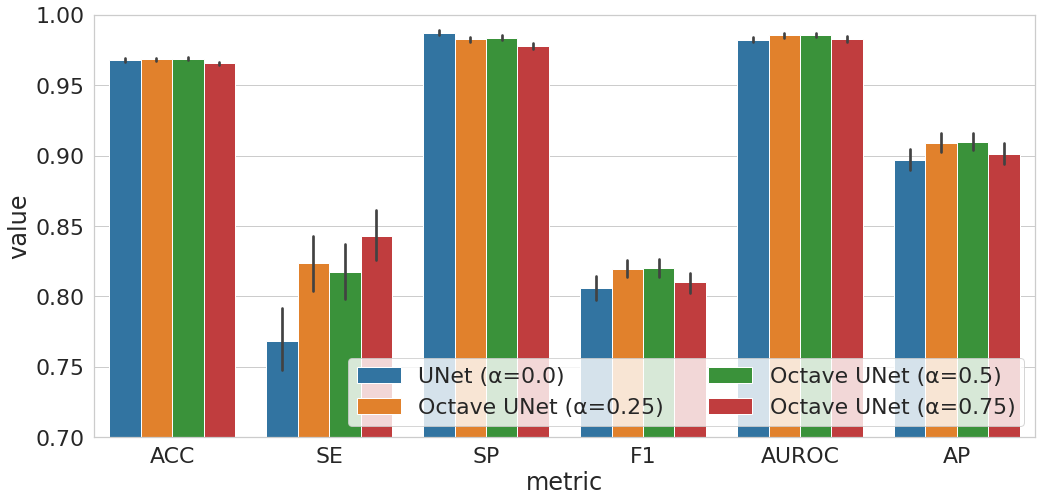

In [8]:
def compare_data_frames_with_barplot(data_frames, exp_names, perf_metrics, 
                                     save_fig=False, figsize=(15, 7.5), 
                                     ylim=(0.7, 1), font_scale=2):
    """Compare experiment performance with barplot."""
    assert len(data_frames) == len(exp_names)
    data_frames = pd.concat(data_frames, ignore_index=True)
    data_frames = data_frames.melt(id_vars=['exp_name'], value_vars=perf_metrics, 
                                   var_name='metric', value_name='value', col_level=None)
    sns.set(style='whitegrid', font_scale=font_scale)
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    box_plot = sns.barplot(x='metric', y='value', hue='exp_name', 
                           data=data_frames, palette='tab10', ax=axis)
    box_plot.set_ylim(ylim)
    box_plot.legend(loc='lower right', ncol=2)
    fig.tight_layout()
    if save_fig:
        fig.savefig('drive-barplot.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)

compare_data_frames_with_barplot(data_frames, exp_names, perf_metrics, save_fig=False)


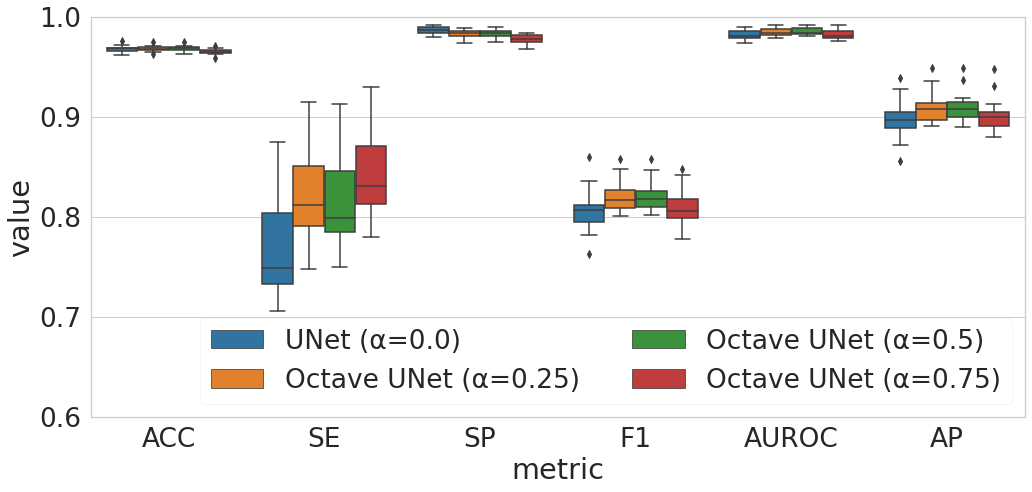

In [9]:
def compare_data_frames_with_boxplot(data_frames, exp_names, perf_metrics, 
                                     save_fig=False, figsize=(15, 7.5), 
                                     font_scale=2, framealpha=0.2, 
                                     ylim=(0.6, 1),
                                     showmeans=False):
    """Compare experiment performance with boxplot."""
    assert len(data_frames) == len(exp_names)
    for data_frame, exp_name in zip(data_frames, exp_names):
        data_frame['exp_name'] = exp_name
    data_frames = pd.concat(data_frames, ignore_index=True)
    data_frames = data_frames.melt(id_vars=['exp_name'], value_vars=perf_metrics, 
                                   var_name='metric', value_name='value', col_level=None)
    sns.set(style='whitegrid', font_scale=font_scale)
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    box_plot = sns.boxplot(x='metric', y='value', hue='exp_name', 
                           data=data_frames, palette='tab10',
                           showmeans=showmeans, ax=axis)
    l = box_plot.legend(loc='lower right', ncol=2, framealpha=framealpha)
    box_plot.set_ylim(ylim)
    fig.tight_layout()
    if save_fig:
        fig.savefig('drive-boxplot.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)

compare_data_frames_with_boxplot(data_frames, 
                                 exp_names=['UNet (α=0.0)',
                                            'Octave UNet (α=0.25)',
                                            'Octave UNet (α=0.5)',
                                            'Octave UNet (α=0.75)'],
                                 perf_metrics=perf_metrics,
                                 save_fig=False, font_scale=2.4)



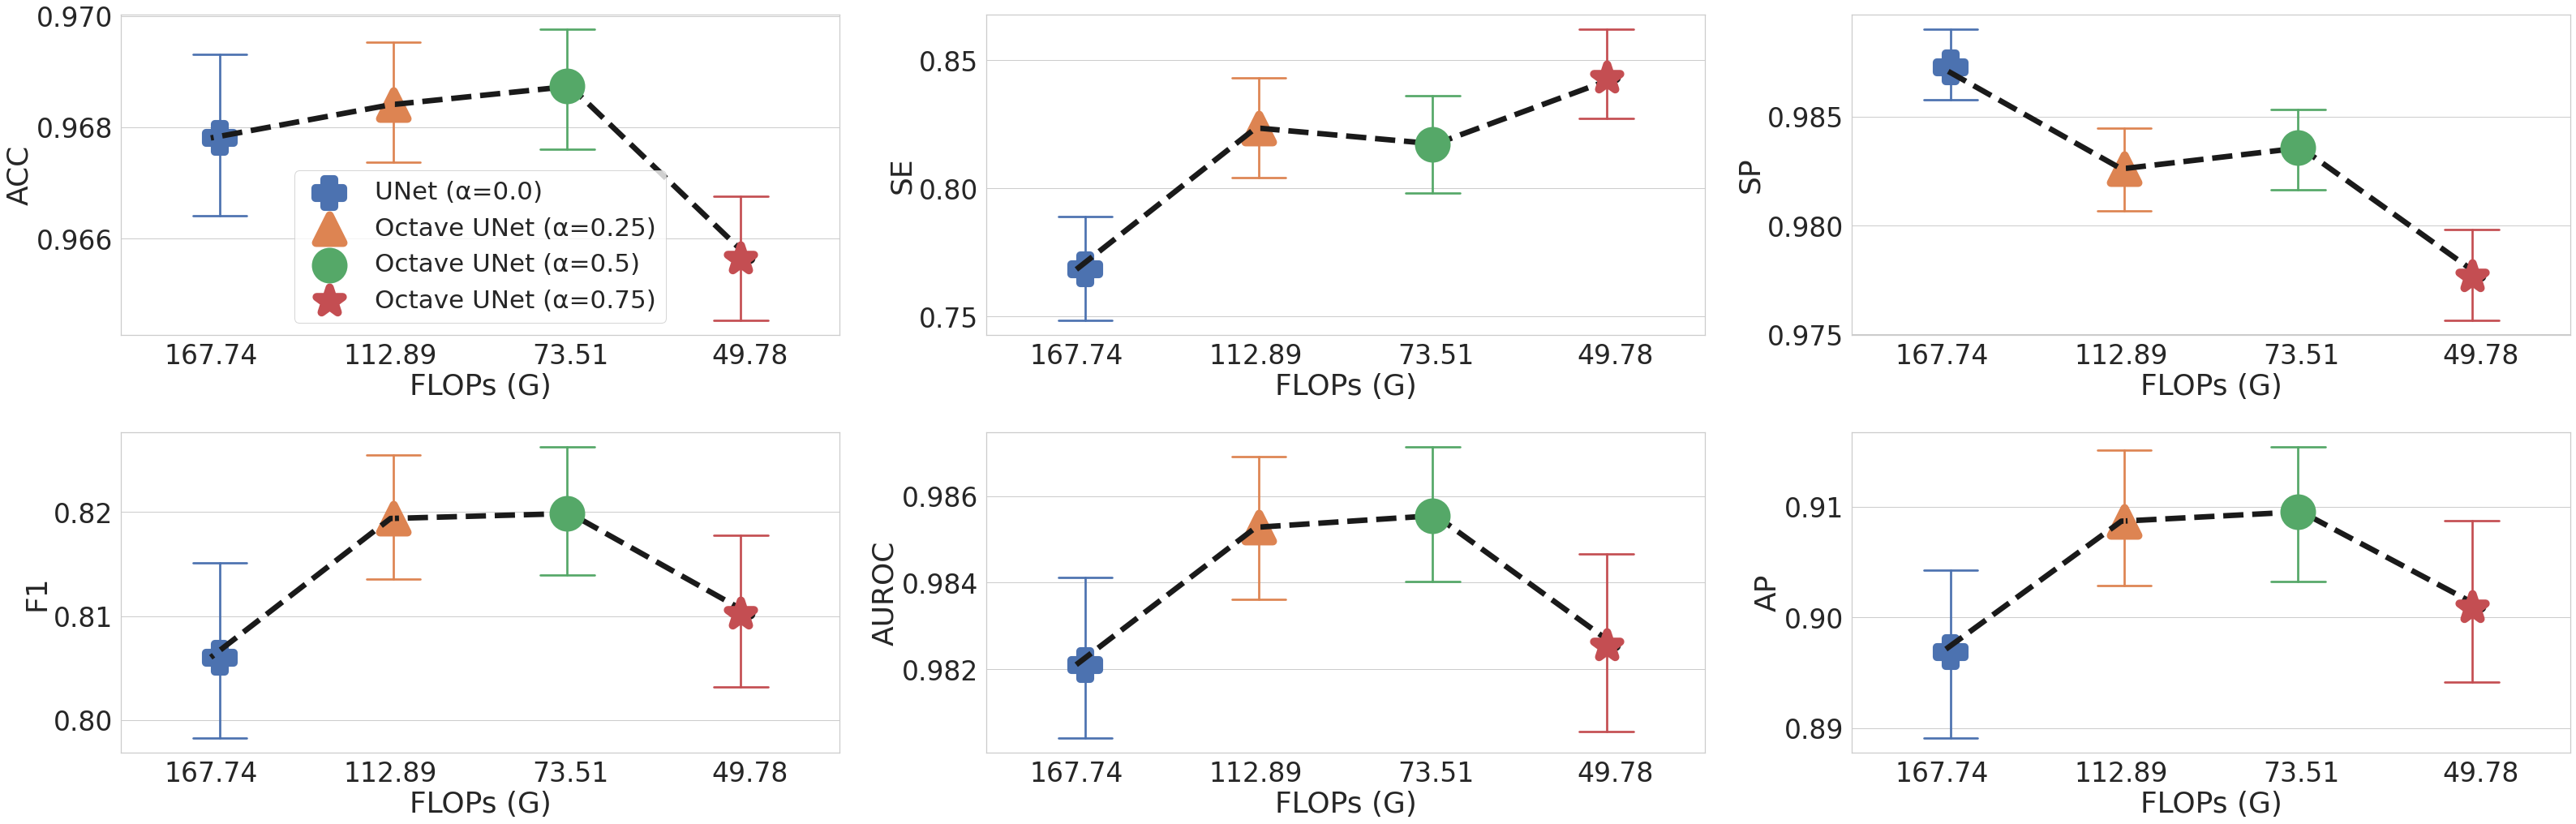

In [10]:
def compare_data_frames_with_paretoplot(data_frames, exp_names, perf_metrics, 
                                        save_fig=False, invert_xaxis=True, font_scale=3):
    """Compare experiment performance with pareto plot."""
    sns.set(style='whitegrid', font_scale=font_scale)
    assert len(data_frames) == len(exp_names)
    data_frames = pd.concat(data_frames, ignore_index=True)
    rows = int(len(perf_metrics) ** 0.5)
    cols = int(np.ceil(len(perf_metrics) / int(len(perf_metrics) ** 0.5)))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*15, rows*7.5))
    axes = axes.ravel()
    for idx, metric in enumerate(perf_metrics):
        g = sns.pointplot(x='FLOPs (G)', y=metric, data=data_frames, ci=None, 
                          markers=['.', '^', 'o', '*'], linestyles='--', dodge=True, color='k',
                          scale=2.5, capsize=0.1, ax=axes[idx])
        g = sns.pointplot(x='FLOPs (G)', y=metric, hue='exp_name', data=data_frames, 
                          markers=['P', '^', 'o', '*'], linestyles='-', dodge=True, 
                          scale=5, capsize=0.3, ax=axes[idx], font_scale=5)
        
        if idx == 0:
            g.legend(loc='best', prop={'size': 31})
        else:
            g._remove_legend(g.get_legend())
        if invert_xaxis:
            g.invert_xaxis()
    plt.tight_layout()
    if save_fig:
        fig.savefig('drive-pareto.pdf')
    plt.show()
    sns.set(style='whitegrid')
    sns.set_context('paper', font_scale=1.5)

compare_data_frames_with_paretoplot(data_frames, exp_names, perf_metrics, 
                                    save_fig=False, font_scale=3)


## Performance of Octave UNet on CHASEDB1 dataset

---


In [11]:
chase_dir = '../experiments/chase'
chase_name = 'Octave UNet (α=0.5)'
chase_data_frame = get_data_frame(chase_dir, chase_name, perf_metrics, monitor_dir)
chase_data_frame = chase_data_frame.rename(columns={'acc': 'ACC', 'se': 'SE', 'sp': 'SP', 'f1': 'F1', 'auroc': 'AUROC', 'ap': 'AP'})
chase_mean = get_data_frame_mean(chase_data_frame, chase_name, perf_metrics)
chase_std = get_data_frame_std(chase_data_frame, chase_name, perf_metrics)

chase_data_frame

,sample_index,weighted_binary_cross_entropy,ACC,SE,SP,F1,prc,AUROC,AP,params (M),FLOPs (G),exp_name
0,20,0.140194,0.980264,0.903627,0.984578,0.829943,0.767370,0.993130,0.919040,16.54,214.35,Octave UNet (α=0.5)
1,21,0.146452,0.977874,0.909687,0.981713,0.814234,0.736911,0.992808,0.908874,16.54,214.35,Octave UNet (α=0.5)
2,22,0.166982,0.966898,0.876076,0.973939,0.792031,0.722700,0.987543,0.878387,16.54,214.35,Octave UNet (α=0.5)
3,23,0.151165,0.970272,0.891566,0.976515,0.815084,0.750687,0.990294,0.907004,16.54,214.35,Octave UNet (α=0.5)
4,24,0.145361,0.976716,0.839100,0.985722,0.815738,0.793642,0.989985,0.901701,16.54,214.35,Octave UNet (α=0.5)
5,25,0.151761,0.973483,0.818393,0.983947,0.795986,0.774772,0.987765,0.883763,16.54,214.35,Octave UNet (α=0.5)
6,26,0.141579,0.975537,0.876737,0.982838,0.831440,0.790594,0.991653,0.919461,16.54,214.35,Octave UNet (α=0.5)
7,27,0.159672,0.969445,0.892192,0.974246,0.773587,0.682816,0.987442,0.890407,16.54,214.35,Octave UNet (α=0.5)


In [12]:
chase_mean

,ACC,SE,SP,F1,AUROC,AP,params (M),FLOPs (G),exp_name
0,0.973811,0.875922,0.980437,0.808505,0.990077,0.90108,16.54,214.35,Octave UNet (α=0.5)


In [13]:
chase_std

,ACC,SE,SP,F1,AUROC,AP,exp_name
0,0.004614,0.03181,0.004792,0.019862,0.002331,0.015517,Octave UNet (α=0.5)


## Performance of Octave UNet on STARE dataset

---



In [30]:
stare_4fold_dirs = ['../experiments/stare-4fold/fold0', '../experiments/stare-4fold/fold1',
                    '../experiments/stare-4fold/fold2', '../experiments/stare-4fold/fold3']

stare_4fold_data_frames = []
for fold_dir in stare_4fold_dirs:
    df = get_data_frame(fold_dir, stare_name, perf_metrics, monitor_dir)
    df = df.rename(columns={'acc': 'ACC', 'se': 'SE', 'sp': 'SP', 'f1': 'F1', 'auroc': 'AUROC', 'ap': 'AP'})
    stare_4fold_data_frames.append(df)

stare_4fold_data_frame = pd.concat(stare_4fold_data_frames, ignore_index=True)


In [31]:
stare_4fold_data_frame

,sample_index,weighted_binary_cross_entropy,ACC,SE,SP,F1,prc,AUROC,AP,params (M),FLOPs (G),exp_name
0,0,0.286913,0.966687,0.801385,0.981024,0.793380,0.785534,0.977665,0.872473,16.54,58.79,Octave UNet (α=0.5)
1,1,0.271747,0.975322,0.752597,0.991214,0.802457,0.859393,0.982332,0.889031,16.54,58.79,Octave UNet (α=0.5)
2,2,0.264203,0.980021,0.869639,0.987048,0.838970,0.810390,0.991294,0.927678,16.54,58.79,Octave UNet (α=0.5)
3,3,0.287766,0.965710,0.691651,0.987651,0.749396,0.817661,0.978398,0.845320,16.54,58.79,Octave UNet (α=0.5)
4,4,0.310460,0.955443,0.840108,0.966896,0.773061,0.715925,0.981044,0.868856,16.54,58.79,Octave UNet (α=0.5)
5,5,0.323330,0.972848,0.889510,0.979087,0.820252,0.761000,0.989284,0.906117,16.54,58.79,Octave UNet (α=0.5)
6,6,0.325645,0.970184,0.956572,0.971370,0.837199,0.744315,0.994096,0.950660,16.54,58.79,Octave UNet (α=0.5)
7,7,0.330022,0.969535,0.953627,0.970818,0.823734,0.724984,0.993976,0.943234,16.54,58.79,Octave UNet (α=0.5)
8,8,0.309176,0.977915,0.935455,0.981540,0.869505,0.812241,0.995794,0.960365,16.54,58.79,Octave UNet (α=0.5)
9,9,0.371958,0.947783,0.955780,0.947083,0.746446,0.612333,0.989713,0.908376,16.54,58.79,Octave UNet (α=0.5)


In [32]:
stare_4fold_mean = get_data_frame_mean(stare_4fold_data_frame, stare_name, perf_metrics)
stare_4fold_std = get_data_frame_std(stare_4fold_data_frame, stare_name, perf_metrics)


In [33]:
stare_4fold_mean

,ACC,SE,SP,F1,AUROC,AP,params (M),FLOPs (G),exp_name
0,0.971367,0.851188,0.980952,0.816971,0.986832,0.911373,16.54,58.79,Octave UNet (α=0.5)


In [34]:
stare_4fold_std

,ACC,SE,SP,F1,AUROC,AP,exp_name
0,0.008966,0.098305,0.010672,0.049545,0.009153,0.043877,Octave UNet (α=0.5)


## Performance of Octave UNet on HRF dataset

---




In [17]:
hrf_dir = '../experiments/hrf'
hrf_name = 'Octave UNet (α=0.5)'
hrf_data_frame = get_data_frame(hrf_dir, hrf_name, perf_metrics, monitor_dir)
hrf_data_frame = hrf_data_frame.rename(columns={'acc': 'ACC', 'se': 'SE', 'sp': 'SP', 'f1': 'F1', 'auroc': 'AUROC', 'ap': 'AP'})
hrf_mean = get_data_frame_mean(hrf_data_frame, hrf_name, perf_metrics)
hrf_std = get_data_frame_std(hrf_data_frame, hrf_name, perf_metrics)

hrf_data_frame

,sample_index,weighted_binary_cross_entropy,ACC,SE,SP,F1,prc,AUROC,AP,params (M),FLOPs (G),exp_name
0,15,0.244110,0.949313,0.800179,0.961488,0.704404,0.629105,0.963238,0.804625,16.54,235.17,Octave UNet (α=0.5)
1,16,0.200162,0.973579,0.823716,0.984581,0.810049,0.796827,0.987982,0.900875,16.54,235.17,Octave UNet (α=0.5)
2,17,0.188686,0.973157,0.773080,0.995735,0.853818,0.953386,0.991569,0.954464,16.54,235.17,Octave UNet (α=0.5)
3,18,0.207953,0.967673,0.826225,0.979598,0.798966,0.773448,0.982449,0.885272,16.54,235.17,Octave UNet (α=0.5)
4,19,0.223074,0.963838,0.909909,0.967590,0.766029,0.661438,0.986351,0.892320,16.54,235.17,Octave UNet (α=0.5)
5,20,0.177439,0.975752,0.909597,0.982216,0.869761,0.833268,0.993780,0.951687,16.54,235.17,Octave UNet (α=0.5)
6,21,0.214392,0.965724,0.837961,0.976115,0.786219,0.740496,0.981924,0.871882,16.54,235.17,Octave UNet (α=0.5)
7,22,0.217601,0.964020,0.908313,0.968069,0.773829,0.674033,0.987216,0.897814,16.54,235.17,Octave UNet (α=0.5)
8,23,0.188545,0.974868,0.795764,0.994868,0.864151,0.945397,0.991767,0.954648,16.54,235.17,Octave UNet (α=0.5)
9,24,0.221539,0.965937,0.764364,0.980572,0.752344,0.740696,0.974914,0.834163,16.54,235.17,Octave UNet (α=0.5)


In [18]:
hrf_mean

,ACC,SE,SP,F1,AUROC,AP,params (M),FLOPs (G),exp_name
0,0.968275,0.841843,0.979148,0.803201,0.984928,0.897365,16.54,235.17,Octave UNet (α=0.5)


In [20]:
hrf_std

,ACC,SE,SP,F1,AUROC,AP,exp_name
0,0.005849,0.053499,0.008372,0.04428,0.006639,0.039996,Octave UNet (α=0.5)
